In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
import rasterio
from netCDF4 import Dataset
from netCDF4 import num2date
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
import random
from datetime import datetime, timedelta
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from rasterio.transform import from_origin
from rasterio.enums import Resampling
import rioxarray

import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [6]:
# interactively display netcdf data 

def load_netcdf_stack(file_path):
    with Dataset(file_path, mode='r') as src:
        # the key for time is for cams_global_reanalysis-eac4 'valid_time'
        # the key for time is for reanalysis-era5-single-levels 'time'
        keyOI = [k for k in src.variables.keys() if k not in ['valid_time', 'latitude', 'longitude']][0]
        stack = src.variables[keyOI][:]
        print(src.variables.keys())
        time_units = src.variables['valid_time'].units
        time_vector = src.variables['valid_time'][:]
        time_vector = num2date(time_vector, units=time_units)
    return stack, time_vector

# Display layer of the stack (colorbar and colormap)
def display_layer(layer_index, stack, descriptions, vmin, vmax, elevation):
    fig, ax = plt.subplots()
        # Resize the stack layer to match the elevation map's shape
    resized_layer = resize(stack[layer_index-1], elevation.shape, mode='reflect', anti_aliasing=True)
    # Then, overlay the stack layer on top of the elevation data
    cax = ax.imshow(resized_layer, cmap='viridis', vmin=vmin, vmax=vmax)

    ax.imshow(elevation, cmap='terrain', alpha=0.15)
    
    ax.set_title(descriptions[layer_index-1])
    ax.axis('off')
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
    plt.show()

# Update the displayed layer
def interactive_display(file_path, elevation):
    stack, time_vector = load_netcdf_stack(file_path)
    num_layers = stack.shape[0]
    
    # global min and max values
    # in visualisation you may play around here 
    vmin = np.min(stack)
    vmax = np.max(stack)

    def plot_layer(layer_index):
        display_layer(layer_index, stack, time_vector, vmin, vmax, elevation)

    slider = interactive(plot_layer, layer_index=(1, num_layers))
    display(slider)

elevation_file = 'test_data\\corine\\12.83_53.54_CORINE_LAND_COVER_1990_100x100_ETRS89.tif'
# Open the GeoTIFF file
with rasterio.open(elevation_file) as src:
    # Read the first band
    elevation = src.read(1)
new_size = (400,400)
elevation = resize(elevation, new_size, mode='reflect', anti_aliasing=True)

file_path = 'test_data\\black_carbon_aerosol_optical_depth_550nm\\2021.nc'

interactive_display(file_path, elevation)

dict_keys(['valid_time', 'latitude', 'longitude', 'bcaod550'])


interactive(children=(IntSlider(value=183, description='layer_index', max=365, min=1), Output()), _dom_classes…

In [7]:
def simple_dummy_data(number_of_subjects, bounding_box):
    min_lat, min_lon, max_lat, max_lon = bounding_box
    latitudes = np.random.uniform(low=min_lat, high=max_lat, size=number_of_subjects)
    longitudes = np.random.uniform(low=min_lon, high=max_lon, size=number_of_subjects)
    # Create a DataFrame
    df = pd.DataFrame({
        'latitude': latitudes,
        'longitude': longitudes
    })
    # Create a GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf.drop(columns=['longitude','latitude'],inplace=True)
    # start_date.value is ni ns and start_date.value // 10**9 in seconds
    gdf['subjectID'] = np.random.permutation(len(gdf))
    gdf.set_crs(epsg=4326, inplace=True)
    return gdf

In [13]:

# Example: enrich subjects time series with netcdf data

# 1. create dummy subject data

number_of_subjects = 1000
europe = [72, -15, 30, 42.5]
sub_df = simple_dummy_data(number_of_subjects, europe)

sub_df['likes monty python'] = ['positive' if i%2==1 else 'negative' for i in range(sub_df.shape[0])]

def generate_random_dates(start_date, end_date, num_dates):
    date_range = (end_date - start_date).days
    random_dates = sorted([start_date + timedelta(days=random.randrange(date_range),
                                                  hours=random.randint(0, 23),
                                                  minutes=random.randint(0, 59)) for _ in range(num_dates)])
    return [date.strftime('%Y-%m-%d %H:%M') for date in random_dates]

# 1.2 add random dates to subjects
start_date = datetime(2021, 1, 1)  # Start of the year 2020
end_date = datetime(2021, 12, 31)  # End of the year 2020
num_dates = number_of_subjects  # Number of random dates to generate

test_df = sub_df.sample(n=num_dates)
test_df['date'] = generate_random_dates(start_date, end_date, num_dates)
date = pd.to_datetime(test_df.iloc[0]['date'])
test_df

,geometry,subjectID,likes monty python,date
658,POINT (-14.50805 46.90400),736,negative,2021-01-01 00:51
374,POINT (19.88771 68.38400),306,negative,2021-01-01 08:43
847,POINT (39.61183 63.75347),173,positive,2021-01-01 20:23
532,POINT (36.39339 45.15285),637,negative,2021-01-01 23:31
707,POINT (-1.18511 44.02090),682,positive,2021-01-02 02:17
...,...,...,...,...
545,POINT (2.77046 40.98776),688,positive,2021-12-29 20:31
424,POINT (-3.78779 38.59623),336,negative,2021-12-29 20:59
538,POINT (40.82448 30.13702),12,negative,2021-12-29 22:15
308,POINT (24.34093 58.41356),995,negative,2021-12-29 23:24


In [14]:
# 2. merge subjct and netcdf data
# Open the netCDF file
file_path = 'test_data\\black_carbon_aerosol_optical_depth_550nm\\2021.nc'
dataset = Dataset(file_path, mode='r')

# Function to find the nearest index for a coordinate
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

# Assuming 'df' is your DataFrame and it has 'geometry' column in 'POINT (lon lat)' format
# Add a new column to store the netCDF values
test_df['netCDF_value'] = np.nan

# Iterate over the DataFrame rows
for index, row in test_df.iterrows():
    # Extract longitude and latitude from the 'geometry' column
    point = row['geometry']
    lon, lat = point.x, point.y
    
    # Find the nearest index in the netCDF file
    lat_idx = find_nearest(dataset.variables['latitude'][:], lat)
    lon_idx = find_nearest(dataset.variables['longitude'][:], lon)
    
    # Convert the date to the appropriate format and find the index
    date = pd.to_datetime(row['date'])
    reference_date = datetime(1900, 1, 1, 0, 0, 0)
    # Calculate the difference in hours
    difference = date - reference_date
    hours_since_reference = difference.total_seconds() / 3600
    time_idx = find_nearest(dataset.variables['valid_time'][:], hours_since_reference)
    # Extract the value from the netCDF file
    keyOI = [k for k in dataset.variables.keys() if k not in ['valid_time', 'latitude', 'longitude']][0]
    # Replace 'variable_of_interest' with the actual variable name you want to extract data from
    value = dataset.variables[keyOI][time_idx, lat_idx, lon_idx]
    
    # Assign the value to the new column in the DataFrame
    test_df.at[index, 'netCDF_value'] = value
dataset.close()
test_df.head(5)

,geometry,subjectID,likes monty python,date,netCDF_value
658,POINT (-14.50805 46.90400),736,negative,2021-01-01 00:51,0.000639
374,POINT (19.88771 68.38400),306,negative,2021-01-01 08:43,0.000665
847,POINT (39.61183 63.75347),173,positive,2021-01-01 20:23,0.000813
532,POINT (36.39339 45.15285),637,negative,2021-01-01 23:31,0.002067
707,POINT (-1.18511 44.02090),682,positive,2021-01-02 02:17,0.000439


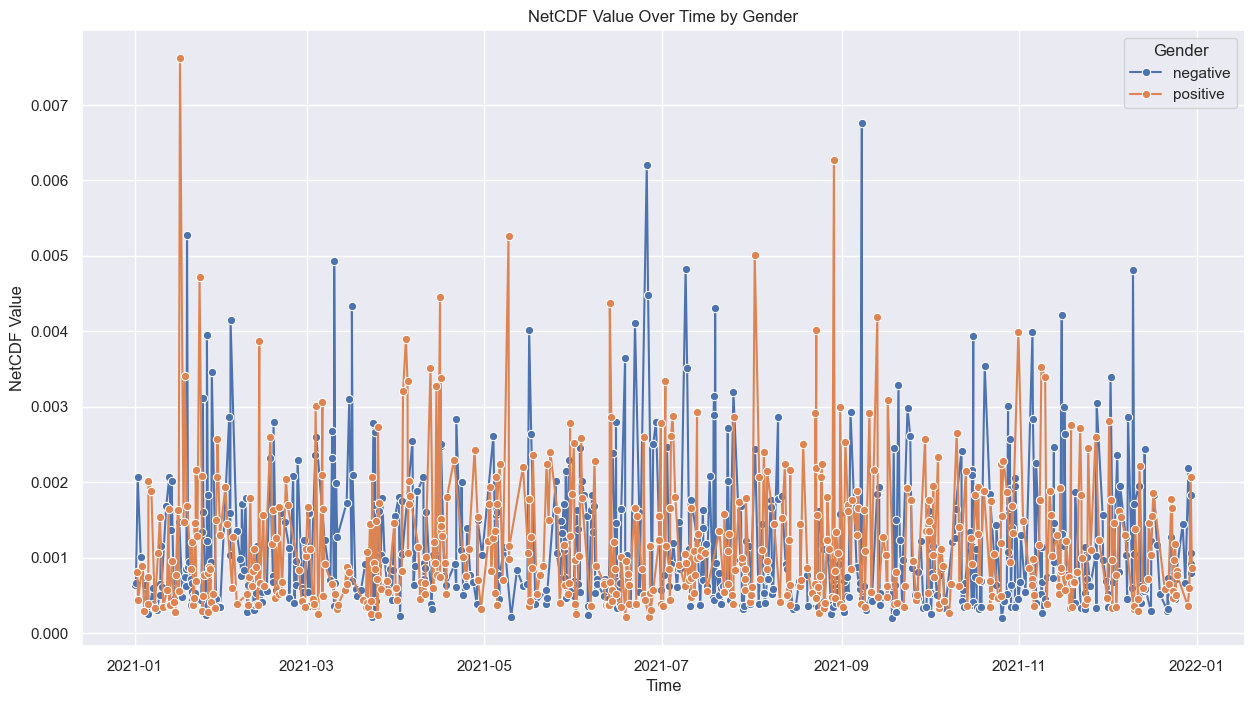

In [15]:
# 3.plt results by gender and date

# Assuming 'df' is your DataFrame with the relevant data
# First, ensure that 'date' is a datetime object and 'netCDF_value' is a float
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['netCDF_value'] = test_df['netCDF_value'].astype(float)

# Set the style of the seaborn plot
sns.set(style="darkgrid")

# Create the plot
plt.figure(figsize=(15, 8))
sns.lineplot(x='date', y='netCDF_value', hue='likes monty python', data=test_df, marker='o')

# Add titles and labels
plt.title('NetCDF Value Over Time by Gender')
plt.xlabel('Time')
plt.ylabel('NetCDF Value')
plt.legend(title='Gender')

# Show the plot
plt.show()

In [18]:
# transform netCDF to geoTIFF stack

def netCDF2GeoTiff(input, output):
    # netCDF -> geoTIFF... not used 
    ds = xr.open_dataset(input)
    # Get the variable name in the file
    var_name_in_file = list(ds.data_vars)[0]

    # Select the variable and convert to a rioxarray object
    data_var = ds[var_name_in_file].rio.set_spatial_dims(x_dim='latitude', y_dim='latitude')
    # Set the CRS (coordinate reference system) if not already set
    data_var = data_var.rio.write_crs("EPSG:4326")

    # Prepare the metadata for the output file
    print(data_var)
    print(data_var.valid_time)
    n_times = len(data_var.valid_time)
    transform = from_origin(data_var.longitude.min(), data_var.latitude.max(), data_var.longitude[1] - data_var.longitude[0], data_var.latitude[1] - data_var.latitude[0])
    meta = {
        'driver': 'GTiff',
        'count': n_times,
        'dtype': 'float32',
        'width': data_var.sizes['longitude'],
        'height': data_var.sizes['latitude'],
        'crs': 'EPSG:4326',
        'transform': transform
    }


    # Write the data to a single GeoTIFF file
    with rasterio.open(output, 'w', **meta) as dst:
        for i in range(n_times):
            # Select data for the current time step
            data = data_var.isel(valid_time=i).values
            # Get the name for the current time step
            time_value = data_var.valid_time[i].values.astype('datetime64[ms]').astype('O')  # Convert to Python datetime object
            name = time_value.strftime('%Y-%m-%d_%H:%M:%S')  # Format the datetime object
            # Write the data to the corresponding band in the GeoTIFF file
            dst.write(data, i + 1)
            # Set the band name
            dst.set_band_description(i + 1, name)

    print(f"Saved {output}")

input = 'test_data\\black_carbon_aerosol_optical_depth_550nm\\2021.nc'
output = "result.tif"
netCDF2GeoTiff(input, output)

<xarray.DataArray 'bcaod550' (valid_time: 365, latitude: 61, longitude: 77)> Size: 7MB
[1714405 values with dtype=float32]
Coordinates:
  * valid_time   (valid_time) datetime64[ns] 3kB 2021-01-01T12:00:00 ... 2021...
  * latitude     (latitude) float64 488B 75.0 74.25 73.5 ... 31.5 30.75 30.0
  * longitude    (longitude) float64 616B -15.0 -14.25 -13.5 ... 40.5 41.25 42.0
    spatial_ref  int32 4B 0
Attributes: (12/33)
    GRIB_paramId:                             210211
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      4697
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_units:                               ~
    long_name:                                Black Carbon Aerosol Optical De...
    units:                                    ~
    standard_name:                       

In [19]:
# make mpeg out of stack

import rasterio
from rasterio.enums import Resampling

def reduce_resolution(input_path, output_path, scale_factor):
    with rasterio.open(input_path) as src:
        # Calculate the new shape
        new_height = int(src.height * scale_factor)
        new_width = int(src.width * scale_factor)
        
        # Read the data and resample
        data = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=Resampling.bilinear
        )
        
        # Update the metadata
        transform = src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )
        metadata = src.meta.copy()
        metadata.update({
            'height': new_height,
            'width': new_width,
            'transform': transform
        })
        
        # Write the resampled data to a new file
        with rasterio.open(output_path, 'w', **metadata) as dst:
            dst.write(data)
            # Copy band descriptions
            for i in range(1, src.count + 1):
                description = src.descriptions[i-1]
                dst.set_band_description(i, description)

# Example usage
input_path = 'result.tif'
output_path = 'result_scaled.tif'
scale_factor = 0.5  # Reduce resolution by half
reduce_resolution(input_path, output_path, scale_factor)

In [20]:
def reduce_resolution(input_path, output_path, scale_factor):
    with rasterio.open(input_path) as src:
        # Calculate the new shape
        new_height = int(src.height * scale_factor)
        new_width = int(src.width * scale_factor)
        
        # Read the data and resample
        data = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=Resampling.bilinear
        )
        
        # Update the metadata
        transform = src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )
        metadata = src.meta.copy()
        metadata.update({
            'height': new_height,
            'width': new_width,
            'transform': transform
        })
        
        # Write the resampled data to a new file
        with rasterio.open(output_path, 'w', **metadata) as dst:
            dst.write(data)
            # Copy band descriptions
            for i in range(1, src.count + 1):
                description = src.descriptions[i-1]
                dst.set_band_description(i, description)

# Example usage
input_path = 'result.tif'
output_path = 'result_scaled.tif'
scale_factor = 0.5  # Reduce resolution by half
reduce_resolution(input_path, output_path, scale_factor)

In [21]:
def geotiff_stack_to_mpeg(input_path, output_path, fps=30, dpi=300):
    with rasterio.open(input_path) as src:
        # Read the entire stack
        stack = src.read()#-274.15
        # Calculate the global min and max
        global_min = stack.min()
        global_max = stack.max()
        
        # Create a colormap
        cmap = plt.get_cmap('coolwarm')
        norm = Normalize(vmin=global_min, vmax=global_max)
        
        writer = imageio.get_writer(output_path, fps=fps, codec='mpeg4')
        
        for i in range(1, src.count + 1):
            # Read each band
            image = src.read(i)#-274.15
            band_description = src.descriptions[i-1]
            # Normalize the image using global min and max
            normalized_image = norm(image)
            # Apply the colormap
            colored_image = cmap(normalized_image)
            # Convert to 8-bit RGB
            colored_image = (colored_image[:, :, :3] * 255).astype(np.uint8)
            
            # Create a figure and axis to add text and scale bar
            fig, ax = plt.subplots(figsize=(10, 10), dpi=dpi)
            im = ax.imshow(colored_image, cmap=cmap, norm=norm)
            ax.text(0.5, 0.95, band_description, transform=ax.transAxes, fontsize=12, color='white', ha='center', va='top')
            ax.axis('off')
            
            # Add a scale bar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            
            # Adjust layout to minimize white frame
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
            fig.tight_layout(pad=0)
            
            # Convert the figure to an image
            fig.canvas.draw()
            image_with_text = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            image_with_text = image_with_text.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            writer.append_data(image_with_text) # The mpeg4 codec requires imageio-ffmpeg if not present -> TypeError: TiffWriter.write() got an unexpected keyword argument 'fps'
            plt.close(fig)
            if i%100==0:
                print(i)
                print(i/src.count)
                #break
        
        writer.close()

# Example usage
input_path = 'result_scaled.tif'
output_path = 'result_dust.mp4'
geotiff_stack_to_mpeg(input_path, output_path, fps=30, dpi=320)

C:\Users\jents\AppData\Local\Temp\ipykernel_36164\2008265438.py:43: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image_with_text = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


100
0.273972602739726
200
0.547945205479452
300
0.821917808219178


In [24]:
# mp4 cannot be displayed in notebook

!ffmpeg -i result_dust.mp4 output_video.webm

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [22]:
from IPython.display import HTML

video_path = 'output_video.webm'
HTML(f"""
<video width="640" height="480" controls>
  <source src="{video_path}" type="video/webm">
  Your browser does not support the video tag.
</video>
""")